In [74]:
from collections import Counter
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### preparing dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
TRAIN_SIZE = 10000
TEST_SIZE = 2000

train_idx = np.arange(len(x_train))
np.random.shuffle(train_idx)
train_idx = train_idx[:TRAIN_SIZE]

test_idx = np.arange(len(x_test))
np.random.shuffle(test_idx)
test_idx = test_idx[:TEST_SIZE]

type(train_idx), train_idx.shape, type(test_idx), test_idx.shape

(numpy.ndarray, (10000,), numpy.ndarray, (2000,))

In [4]:
train_images, train_labels = x_train[train_idx], y_train[train_idx]
test_images, test_labels = x_test[test_idx], y_test[test_idx]

assert train_images.shape == (TRAIN_SIZE, 32, 32, 3)
assert test_images.shape == (TEST_SIZE, 32, 32, 3)
assert train_labels.shape == (TRAIN_SIZE, 1)
assert test_labels.shape == (TEST_SIZE, 1)

np.unique(train_labels, return_counts=True), np.unique(test_labels, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1020,  970,  997,  992, 1005,  990,  995,  992, 1030, 1009])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([210, 193, 198, 181, 201, 216, 188, 213, 192, 208])))

In [5]:
Counter(y_train[:, 0])

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})

well this is working :), we have sampled small set of all features equally

In [6]:
train_images, test_images = train_images / 255.0, test_images / 255.0

### plotting

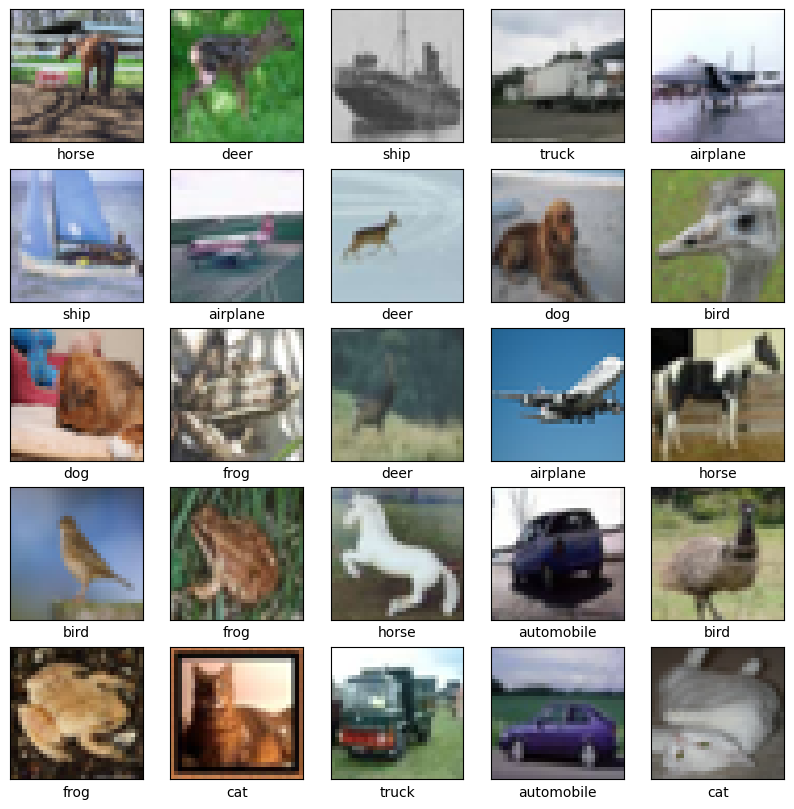

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### model

In [8]:
img_height,img_width = 32, 32

In [24]:
model = keras.applications.resnet50.ResNet50(weights= None, include_top=True, input_shape= (img_height,img_width,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=4,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=2,
    min_lr=0.00001,
)

In [29]:
history = model.fit(train_images, train_labels, 
                    epochs=50,
                    callbacks = [lr_scheduler],
                    validation_data=(test_images, test_labels))

Epoch 1/50
313/313 [==============================] - 54s 50ms/step - loss: 2.3698 - accuracy: 0.2669 - val_loss: 2.6570 - val_accuracy: 0.1615 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 14s 45ms/step - loss: 1.9333 - accuracy: 0.3797 - val_loss: 31.4025 - val_accuracy: 0.1900 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 14s 44ms/step - loss: 1.8781 - accuracy: 0.4064 - val_loss: 377.3444 - val_accuracy: 0.1465 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 14s 44ms/step - loss: 1.7856 - accuracy: 0.4326 - val_loss: 2.0195 - val_accuracy: 0.3255 - lr: 0.0010
Epoch 5/50
313/313 [==============================] - 14s 45ms/step - loss: 1.7635 - accuracy: 0.4771 - val_loss: 2.2299 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 6/50
313/313 [==============================] - 14s 44ms/step - loss: 1.7458 - accuracy: 0.4835 - val_loss: 709.8171 - val_accuracy: 0.0945 - lr: 0.0010
Epoch 7/50
313/313 [==============================] -

### model accuracy

63/63 - 1s - loss: 2.9490 - accuracy: 0.5885 - 786ms/epoch - 12ms/step


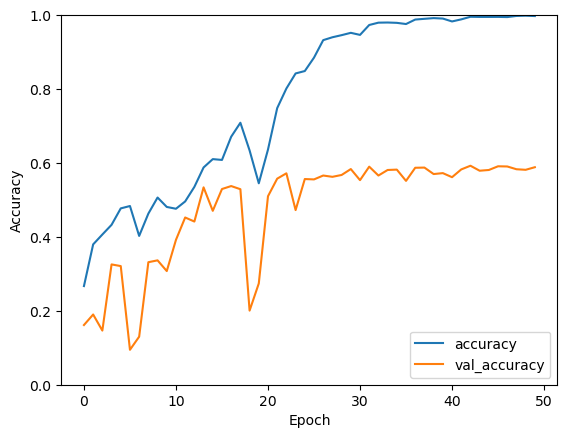

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2);

clearly overfitting :)

#### weight values

* looking at the maximum, minimum and average value of each trainable layer

In [79]:
info_ = {'name':[], 'max_weight': [], 'min_weight': [], 'avg_weight': []}
for i, layer in enumerate(model.layers):
    info_['name'].append(layer.name)
    try:
        weights = model.get_layer(layer.name).get_weights()
        max_ = []
        min_ = []
        avg_ = []
        for weight in weights:
            max_.append(np.max(weight))
            min_.append(np.min(weight))
            avg_.append(np.mean(weight))
        info_['max_weight'].append(max_)
        info_['min_weight'].append(min_)
        info_['avg_weight'].append(avg_)

    except Exception as e:
        print("exception occured", type(e).__name__)
        info_['max_weight'].append(np.nan)
        info_['min_weight'].append(np.nan)
        info_['avg_weight'].append(np.nan)
weights_info = pd.DataFrame(info_)
weights_info

,name,max_weight,min_weight,avg_weight
0,input_3,[],[],[]
1,conv1_pad,[],[],[]
2,conv1_conv,"[0.1824668, 0.056601506]","[-0.17676361, -0.05516624]","[0.002362966, -0.0003746602]"
3,conv1_bn,"[1.2754815, 0.20833208, 1.5920824, 0.5339803]","[0.88853824, -0.13347451, -0.9697991, 0.015257...","[0.99523175, 0.03864321, 0.1329236, 0.14036918]"
4,conv1_relu,[],[],[]
...,...,...,...,...
172,conv5_block3_3_bn,"[1.2526366, 0.10782108, 1.937892, 52.124615]","[0.57579607, -0.3131366, -1.8072958, 0.25139943]","[0.8690173, -0.13041857, 0.031048674, 13.436961]"
173,conv5_block3_add,[],[],[]
174,conv5_block3_out,[],[],[]
175,avg_pool,[],[],[]


* so the above table shows the maximum wights of each layer in the model
* for each layer we have a list of max, min, avg values because
    * that are because layers have wights and bias
* some lists are empty because these layers are not trainable  or there are ni weights associated with them

### visualizing kernels

In [80]:
layer = 'conv1_conv'
conv1_conv_weights, conv1_conv_biases = model.get_layer(layer).get_weights()
type(conv1_conv_weights), type(conv1_conv_biases), conv1_conv_weights.shape, conv1_conv_biases.shape

(numpy.ndarray, numpy.ndarray, (7, 7, 3, 64), (64,))

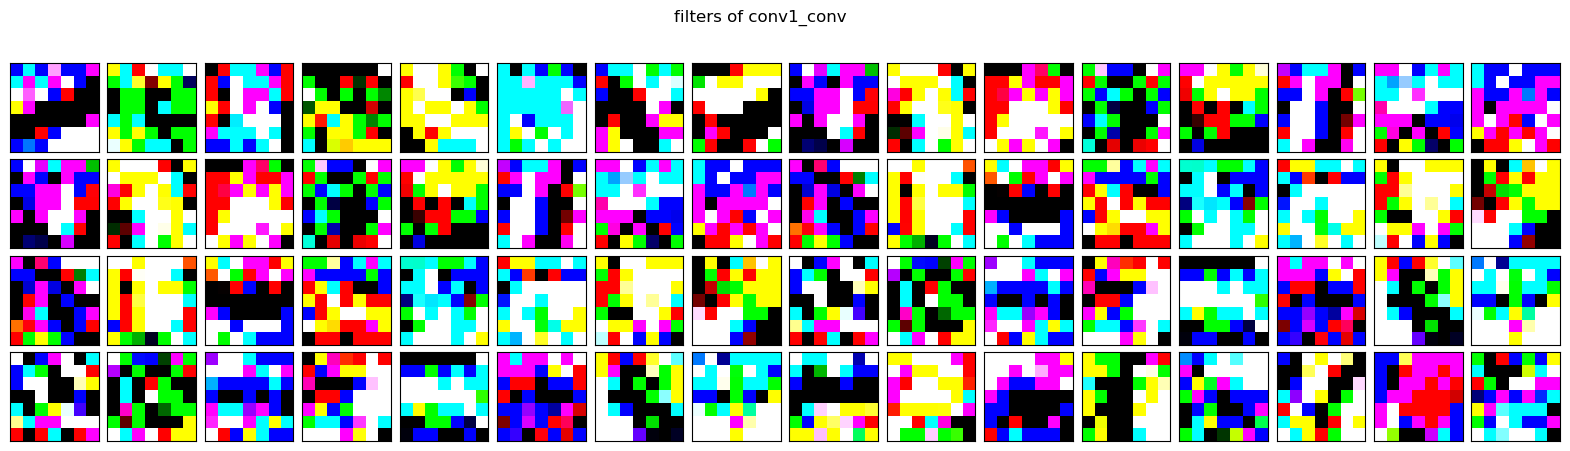

In [88]:
fig = plt.figure(figsize=(20, 5), constrained_layout=False)
grid_spec = fig.add_gridspec(4, 16, wspace=0.1, hspace=0.01) #create a grid spec
axs = grid_spec.subplots() #get all the subplots in this gridspec
for (i, j), ax in np.ndenumerate(axs): #enumerating in these axes (0, 1), (0,2) ... (1, 0), (1, 1) ...
    ax.set(xticks=[], yticks=[])
    ax.imshow(conv1_conv_weights[:, :, :, 8*i+j]*255)
fig.show()
fig.suptitle(f'filters of {layer}');

* the above figure shows kernel of first layer
* change layer name to visualize other layers, 
    * have to change grid spec and figure subplots
    * and restructre weights matrix accordingly

Thank You :)